# WORKING DOCUMENT! --> a lot of bullsht in here

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#input: data, expected peaks (substrate and metabolite)(dictionary?/two lists?
data = pd.read_csv('../Data/FA_20231113_2H_yeast_Pyruvate-d3_5.csv')

#expected peaks for different substrates
Pyruvate_compound = ['Substrate', 'metabolite1', 'metabolite2']
peaks_pyruvate= [2.468, 1.2261, 1.9775]

spectra_data= data.iloc[:,1:]
chem_shifts = data.iloc[:,0] 

In [3]:
def simple_viz(data):
    import seaborn as sns
    import matplotlib.pyplot as plt

    chem_shifts = data.iloc[:, 0]

    plt.figure(figsize=(10, 6))
    for i in range(1, data.shape[1]):
        sns.lineplot(x=chem_shifts, y=data.iloc[:, i])

    plt.xlabel('Chemical Shifts')
    plt.ylabel('Intensity')
    plt.show()

---
# Peak_fit and peakfit_sum

In [4]:
#define function to check for peaks in sum with high threshold

def peak_fit(intensity, chem_shifts, threshold_percentile):
    """calculates possible peaks as minima of the second derivative and returns list of peaks

    Args:
        spectra_data (_type_): x data of spectra
        chem_shifts (_type_): y data of spectra
        threshold_percentile (int | float): Threshold above which the relevant data lies

    Returns:
        list: peak positions
    """
    threshold = np.percentile(intensity, threshold_percentile)
    first_derivative = np.gradient(intensity, chem_shifts)
    second_derivative = np.gradient(first_derivative, chem_shifts)
    third_derivative = np.gradient(second_derivative, chem_shifts)
    fourth_derivative = np.gradient(third_derivative, chem_shifts)

    sign_change = np.diff(np.sign(third_derivative)) != 0
    peak_mask = (intensity > threshold) & (second_derivative < 0) & (fourth_derivative > 0)
    peak_mask[1:] &= sign_change

    return chem_shifts[peak_mask].tolist()


def peakfit_sum(spectra_data, chem_shifts, threshold):
    """sums up all spectra and returns list of found peaks (needs existing function peak_fit)

    Args:
        filename (str): file with spectra data
        threshold_percentile (int | float): Threshold above which the relevant data lies
    """
    sum_of_spectra = np.sum(spectra_data, axis=1)
    peak_pos = peak_fit(sum_of_spectra, chem_shifts, threshold)

    return peak_pos


In [5]:
#get peaks in sum of sepctra
peak_pos = peakfit_sum(spectra_data, chem_shifts, 85)

---
# normalize_water (added)

In [6]:
def normalize_water(data:pd.DataFrame):
    """adjusts the data to the chem_shift(water) = 4.7, based on the closest peak in summed up spectra
    --> needs existing function 'peakfit_sum', peak_fit

    Args:
        data (pd.DataFrame): spectra data with chem_shift in first column

    Returns:
        data_normalized (pd.DataFrame): dataframe with normalized data
    """

    spectra_data= data.iloc[:,1:]
    chem_shifts = data.iloc[:,0] 

    peak_pos = peakfit_sum(spectra_data, chem_shifts, 85)

    #identify water peak (closest to 4.7
    water = 4.7
    closest_peak = min(peak_pos, key=lambda x: abs(x - water))

    # reposition the whole spectra
    data_normalized = pd.DataFrame(chem_shifts.copy() + ( 4.7 - closest_peak))
    data_normalized = pd.concat([data_normalized, data.iloc[:, 1:]], axis=1)

    # Neubenennung der Spalten, um die Originalstruktur zu erhalten
    data_normalized.columns = data.columns

    return data_normalized


In [7]:
data_normalized = normalize_water(data)

In [8]:
#test
print(peak_pos)
print(peakfit_sum(data_normalized.iloc[:,1:], data_normalized.iloc[:,0], 85))

[1.23428, 1.38903, 1.53972, 1.97548, 2.4316, 4.70407]
[1.2302100000000005, 1.3849600000000004, 1.5356500000000004, 1.9714100000000003, 2.4275300000000004, 4.7]


---
# Identify Peaks based on similarity to expected peaks

<div class="alert alert-block alert-warning">
was wenn bereits gematchter Peak weiter weg von peak als ein nachher gefndener? --> Peak nicht vorhancden aber in anderem zeitlichen Abschnitt

In [9]:
def peak_identify(data_normalized: pd.DataFrame, expected_peaks: list,  compound_names: list, initial_threshold = 85, max_shift = 0.15):
    """searches for peaks and matches them to the closest expected peak respecting the maximal shift. 
    Unidentified peaks are added to other(list). 
    Threshold is lowered until all expected peaks are found or number of other peaks succeeds numer of expected peaks
    
    needs existing function 'peakfit_sum'
    
    Args:
        data_normalized (pd.DataFrame): _description_
        compound_names (list): list with names of expected compunds (optional)
        expected_peaks (list): list with positions of expected peaks
        max_shift: maximum distance to expected peak position for 

    Returns:
        found (list): list with identified peaks most likely the expected ones
        other (list):  list with other found peaks
    """

    spectra_data= data_normalized.iloc[:,1:]
    chem_shifts = data_normalized.iloc[:,0]

    #create enpty lists for found and identified peaks
    found = [None] * len(expected_peaks)
    other = []
    threshold = initial_threshold

    while None in found or len(other) <= len(found):
        
        #search for peaks above given threshold
        detected_peaks = peakfit_sum(spectra_data, chem_shifts, threshold)
        
        for peak in detected_peaks:
            distances = [abs(peak - expected_peak) for expected_peak in expected_peaks]
            min_distance = min(distances)
            index = distances.index(min_distance)
            
            if min_distance <= max_shift:
                if found[index] is None:
                    found[index] = peak
                elif found[index] != peak:
                    other.append(peak)
            elif min_distance > max_shift:
                other.append(peak)
            
        threshold -= 2

        if threshold < 0 or None not in found or len(other) > len(found):
            if None not in found:
                print('allet jefunden')
                break
            else: 
                break

    print("Found Peaks: ", found)
    print("Other Peaks: ", other)

    return found, other

In [10]:
Pyruvate_compound = ['Substrate', 'metabolite1', 'metabolite2']
peaks_pyruvate= [2.468, 1.2261, 1.9775]

peak_identify(data_normalized, peaks_pyruvate, Pyruvate_compound)

allet jefunden
Found Peaks:  [2.4275300000000004, 1.2302100000000005, 1.9714100000000003]
Other Peaks:  [1.3849600000000004, 1.5356500000000004, 4.7]


([2.4275300000000004, 1.2302100000000005, 1.9714100000000003],
 [1.3849600000000004, 1.5356500000000004, 4.7])

---
## Visualization (validation)

In [11]:
def plot(data_normalized, compound_names, expected_peaks = []):
    """runs full peak identification process and creates a visualization
    needs existing function peak_identify and all connected

    Args:
        data_normalized (_type_): _description_
        compound_names (_type_): _description_
        expected_peaks (list, optional): _description_. Defaults to [].
    """

    spectra_data= data_normalized.iloc[:,1:]
    chem_shifts = data_normalized.iloc[:,0]
    # Summiere die Spektren aus
    summed_spectra = spectra_data.sum(axis=1)
    found, other = peak_identify(data_normalized, expected_peaks, compound_names)
    
    # Plotte das aussummierte Spektrum
    plt.plot(chem_shifts, summed_spectra, label='sum of spectra')
    
    # Zeichne die gefundenen Peaks
    for peak in found:
        if peak is not None:
            plt.axvline(x=peak, color='r', linestyle='--')
    for peak in other:
        plt.axvline(x=peak, color='orange', linestyle='--')
    
    plt.xlabel('chem_shift')
    plt.ylabel('intensity')
    plt.title('sum of spectra')
    plt.legend()
    plt.show()
   

allet jefunden
Found Peaks:  [2.4275300000000004, 1.2302100000000005, 1.9714100000000003]
Other Peaks:  [1.3849600000000004, 1.5356500000000004, 4.7]


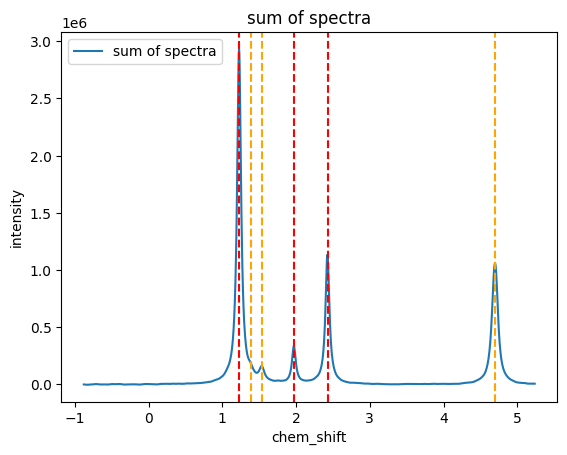

In [12]:
plot(data_normalized, Pyruvate_compound, peaks_pyruvate)

---
---
# Find Peaks separated into three parts

In [13]:
# Spaltenanzahl ohne die chem_shift-Spalte ermitteln
cols_to_divide = len(data.columns) - 1

# Die Anzahl der Spalten für jeden neuen DataFrame berechnen
cols_per_part = cols_to_divide // 3

# DataFrames erstellen
df_part1 = data.iloc[:, :cols_per_part + 1]
df_part2 = data.iloc[:, [0] + list(range(cols_per_part + 1, 2 * cols_per_part + 1))]
df_part3 = data.iloc[:, [0] + list(range(2 * cols_per_part + 1, cols_to_divide + 1))]

---
# combined function 

bullshot, nihct columns dividen sondern lines

In [14]:
def peak_identification_full(data, expected_peaks, shift_tol = 0.01):
    #normalize data
    df = normalize_water(data)


    #separate data into three parts
    cols_to_divide = len(data.columns) - 1
    cols_per_part = cols_to_divide // 3

    df_part1 = data.iloc[:, :cols_per_part + 1]
    df_part2 = data.iloc[:, [0] + list(range(cols_per_part + 1, 2 * cols_per_part + 1))]
    df_part3 = data.iloc[:, [0] + list(range(2 * cols_per_part + 1, cols_to_divide + 1))]


    #find peaks
    found1, other1 = peak_identify(df_part1, expected_peaks)
    found2, other2 = peak_identify(df_part2, expected_peaks)
    found3, other3 = peak_identify(df_part3, expected_peaks)
    
    #combine results,
    #what is maximum shift over time --> 0.01?
    #problem if peaks shift over time and are suddenly more similar to other compund --> fuck

    #chat gpt
    found_lists = [found1, found2, found3]
    other_lists = [other1, other2, other3]

    final_found = []
    final_other= []

    # Zusammenführen und Filtern der "found" Listen
    for i in range(len(expected_peaks)):
        current_peaks = [found[i] for found in found_lists if i < len(found)]

        if current_peaks: #add value thats closest to expected peak to final list
            closest_peak = min(current_peaks, key=lambda x: abs(x - expected_peaks[i]))
            final_found.append(closest_peak)
            
            for peak in current_peaks:
                if abs(peak - closest_peak) >= shift_tol: #<<-- tolerance for peak shift over time
                    final_other.append(peak)

    # Entfernen von Duplikaten und ähnlichen Werten in der "other" Liste
    for other in other_lists:
        for peak in other:
            if not any(abs(peak - o) < shift_tol for o in final_other): 
                final_other.append(peak)



    # Zur Vermeidung von Duplikaten in 'final_other' nach dem Zusammenführen.
    filtered_final_other = []
    for o in final_other:
        if not any(abs(o - ffo) < shift_tol for ffo in filtered_final_other):
            filtered_final_other.append(o)

    final_other = filtered_final_other
    ### chat gpt ende


    peak_pos = final_found + final_other

    return peak_pos
    #return final_found, final_other


<div class="alert alert-box alert-warning">
split into more than 3, at least 20(?) per part

dataframe |timeframe|list of xvalues|

---
---
# full visualization

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec